# Classifier

## Importing Relevant Libraries

In [1208]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
import seaborn as sns
import random
import torch.cuda
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.linalg import svd
import seaborn as sns
from sklearn.impute import KNNImputer
from IPython.display import display, clear_output
import random
from sklearn.cluster import KMeans

# Define Classes

In [1209]:
class Classifier_Net(nn.Module):
    def __init__(self, inputs):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.linear1 = nn.Linear(inputs, 256)
        self.linear2 = nn.Linear(256,512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256,1)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.sigmoid(self.linear4(x))
        return x
    
    def save(self, file_name='model.pth', index=0):
        model_folder_path = './Classifier_models/model' 
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        complete_file_name = f"{index}_{file_name}"
        file_path = os.path.join(model_folder_path, complete_file_name)
        
        torch.save(self.state_dict(), file_path)
    
class Classifier_Trainer:
    def __init__(self, model, lr):
        self.lr = lr
        self.model = model
        self.device = model.device
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.BCEWithLogitsLoss()

    def train_step(self, state, outcome):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)

        # Make a prediction
        pred = self.model(state)[0]

        self.optimizer.zero_grad()

        ## Calculate MSE loss on target and prediction
        loss = self.criterion(pred, outcome[0])
        loss.backward()

        self.optimizer.step()


## Agent tager filepath som input hvis man vil køre en model, der allerede er trænet.
class Agent:
    def __init__(self, inputs, file_path=None, training=True, device=None, 
                 learning_rate=0.01, model_name='testing', data=None):
        self.data = data
        self.MAX_MEMORY = 5_000 ## Længde af buffer
        self.memory = deque(maxlen=self.MAX_MEMORY)  ## popleft() buffer
        self.BATCH_SIZE = 32 ## Sample størrelse
        self.LR = learning_rate ## Learning rate (TIDLIGERE 0.01 for onestep)
        if device is not None: ## Her kan man vælge at køre cpu selvom man har cuda
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        inputs = inputs + len(self.data.T) -1
        self.model = Classifier_Net(inputs=inputs).to(self.device) 
        self.model_name = model_name

        ## Definerer en masse variable baseret på __init__ input
        self.is_training = training
        self.file_path = file_path

        ## Hvis vi har en sti til en model, vil vi loade den i stedet for at træne en ny
        if self.file_path is not None:
            self.model.load_state_dict(torch.load(self.file_path, map_location=self.device))
            self.model.eval()

        ## Initialisér trainer
        self.trainer = Classifier_Trainer(self.model, lr=self.LR)

        ## Træner short memory
    def train_short_memory(self, state, outcome):
        self.trainer.train_step(state, outcome)

        ## Bestem en action
    def get_action(self, state):

        ## Laver state om til tensor og får en prediction fra modellen
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).clone().detach()
        prediction = self.model(state_tensor)

        return torch.round(prediction).item()
    
    def train(self, rounds, pcs, loading=False, evaluating=False):
        accur = np.zeros(rounds)
        lower_acc = np.zeros(rounds)
        upper_acc = np.zeros(rounds)
        pos_accuracy = np.zeros(rounds)
        neg_accuracy = np.zeros(rounds)
        pos_outcome_tracker = []
        neg_outcome_tracker = []
        misclassified_obs = []
        for j in range(rounds):
            res = []
            for i in range(len(self.data)):
                state = self.data[i,:len(self.data.T)-1]
                pc_vals = [pc @ state for pc in pcs]
                state = np.concatenate((state, pc_vals))
                outcome = self.data[i,-1]
                outcome = torch.tensor([float(outcome)]).to(self.device)
                decision = self.get_action(state)
                reward = 1 if decision == outcome else 0

                if outcome.item() == 1:
                    ## Personen fik diabetes
                    if decision == 1: pos_outcome_tracker.append(1)
                    else: pos_outcome_tracker.append(0)
                else:
                    ## Personen fik ikke diabetes
                    if decision == 0: neg_outcome_tracker.append(1)
                    else: neg_outcome_tracker.append(0)

                if self.is_training: 
                    self.train_short_memory(state, outcome=outcome)
                else: 
                    if reward == 0: misclassified_obs.append(self.data[i])

                res.append(reward)

            p_hat = np.mean(res)
            lower, upper =p_hat - 1.96*np.sqrt((p_hat*(1-p_hat))/len(res)), p_hat + 1.96*np.sqrt((p_hat*(1-p_hat))/len(res))

            if j % (rounds/20) == 0 and loading:
                print(f'Loading: {int((j)/rounds*100)}%'*self.is_training,'Mean', round(np.mean(res),2), 
                      'CI:', round(lower,2), round(upper,2))
                
            accur[j] = np.mean(res)
            lower_acc[j], upper_acc[j] = lower, upper
        self.model.save()
        
        if evaluating:
            pos_accuracy = np.mean(pos_outcome_tracker)
            neg_accuracy = np.mean(neg_outcome_tracker)
            return accur[0], lower_acc[0], upper_acc[0], pos_accuracy, neg_accuracy, misclassified_obs

        return np.concatenate(([accur], [lower_acc], [upper_acc]), axis=0)

# Handling Data

In [1210]:
# Read csv file to pd DataFrame
df = pd.read_csv('diabetes.csv')

# Replace 0's with NaN in columns where 0's are not possible
for col in df.columns:
    if col in ['Pregnancies', 'Outcome']:
        continue
    df[col] = df[col].replace(0, np.nan)

# Remove NaN rows in data
def remove_nan(DataFrame):
    return DataFrame.copy().dropna()

def impute_nan(DataFrame, n=None):
    global n_nearest_neighbors
    imputer = KNNImputer(n_neighbors=(n if n is not None else n_nearest_neighbors))
    imputed_array = imputer.fit_transform(DataFrame)
    imputed_df = pd.DataFrame(data=imputed_array, columns=DataFrame.columns)
    return  imputed_df


## Removing Outliers

In [1211]:
def remove_outliers(DataFrame):
    # Calculate the mean and standard deviation for each column
    means = DataFrame.mean()
    stds = DataFrame.std()
    DataFrame = DataFrame.copy()

    global std_threshold

    # Create boolean DataFrame indicating whether or not observations exceed threshold
    conditions = (DataFrame < (means - std_threshold * stds)) | (DataFrame > (means + std_threshold * stds))

    # Any row that should be removed will have at least one True in the conditions DataFrame
    rows_to_remove = conditions.any(axis=1)

    # Remove the rows that meet the condition
    DataFrame = DataFrame[~rows_to_remove]
    return DataFrame

### Splitting data into k groups

In [1212]:
def k_split(DataFrame, k, RemoveOutliers=False, ImputeMissing=False, log_transform=None, remove_misclassified = False):
    'If not ImputeMissing, NaNs will be removed. NaNs will always be removed in test data.'

    ## Get the global features and drop_columns variables
    global features
    global drop_columns

    DataFrame = DataFrame.copy()

    ## Removing observations misclassified by the k-means clustering algorithm
    if remove_misclassified:
        DataFrame = remove_misclassified_observations(DataFrame=DataFrame)

    ## Log transformation
    if log_transform is not None:
        for col in log_transform:
            ## Make sure that we are not log-transforming non-existent columns
            if col in features:
                DataFrame[col] = DataFrame[col].apply(lambda x: np.log1p(x))

    ## Remove unwanted columns
    unwanted = []
    for feature in drop_columns:
        if not feature == 'Outcome':
            unwanted.append(feature)
    DataFrame = DataFrame.drop(columns=unwanted)

    ## Shuffle the DataFrame
    shuffled = DataFrame.sample(frac=1)

    ## Split into k groups
    groups = np.array_split(shuffled, k)

    X_data = []
    Y_data = []
    pc_array = []


    for i in range(k):
        groups_copy = groups.copy()
        test_data = groups_copy.pop(i)

        training_frames = pd.concat(groups_copy)
        if ImputeMissing:
            training_frames = impute_nan(DataFrame=training_frames)
        else:
            training_frames = remove_nan(DataFrame=training_frames)
        if RemoveOutliers:
            training_frames = remove_outliers(DataFrame=training_frames)
        training_standard = training_frames.loc[:, features].values

        ## Create instance of StandardScaler and fit it on the training data
        ## by fitting on training data, we ensure avoidance of information leakage from test data
        scaler = StandardScaler().fit(training_standard)

        ## Transofmr training data
        training_standard = scaler.transform(training_standard)
        
        ## Add Outcome column to training data
        training_standard = np.column_stack((training_standard, training_frames['Outcome']))
        X_data.append(training_standard)

        ## We do not want to impute the NaNs on the data, we are using to evaluate the model.
        ## In this case, NaNs will be removed. Outliers will stay - may want to change that.
        test_data = remove_nan(DataFrame=test_data)
        if RemoveOutliers:
            test_data = remove_outliers(DataFrame=test_data)
        test_standard = test_data.loc[:, features].values

        ## Standardize the test data according to the mean and std of training data
        test_standard = scaler.transform(test_standard)

        ## Add Outcome to test data
        test_standard = np.column_stack((test_standard, test_data['Outcome']))
        Y_data.append(test_standard)


        ## Perform PCA
        %run pca.ipynb 
        data_drop_outcome = np.array([row[:-1] for row in X_data[i]])
        Vh = get_PCs(data_drop_outcome)
        pc_array.append(Vh)

    return X_data, Y_data, np.array(pc_array)


# Define the cross-validation function

In [1213]:
def cross_validate(training_data, test_data, pcs, n_pcs, learning_rate, rtt, plot=False, loading=False):
    print(f'Working on:', 'CUDA' if torch.cuda.is_available() else 'CPU')
    validation_stats = []
    mco_frames = []
    for i in range(len(training_data)):
        X= training_data[i]
        Y = test_data[i]

        components = [pcs[i][j] for j in range(n_pcs)]


        agent = Agent(learning_rate=learning_rate, data=X, inputs=n_pcs)
        training_accuracy = agent.train(rtt, loading=loading, pcs=components)
        if plot:
            sns.lineplot(pd.DataFrame(training_accuracy.T, columns=['Accuracy', 'CI Lower Bound', 'CI Upper Bound']))
            plt.xlabel('Rounds')
            plt.ylabel('Accuracy')
            plt.title('Training Accuracy')

        if loading: print('\nEval')
        agent = Agent(training=False, file_path='Classifier_models/model/0_model.pth', data=Y, inputs=n_pcs)
        final_stats = agent.train(1, loading=loading, pcs=components, evaluating=True)
        final_accuracy, final_lower_bound, final_upper_bound, positive_acc, negative_acc, mco = final_stats
        print(i+1,round(final_accuracy,2))
        print('False Negative %', np.round(1-positive_acc,2), 'False Positive %', np.round(1-negative_acc,2),'\n')
        print('Misclassified observations:', len(mco), '/', len(Y))
        global features
        mco_frames.append(pd.DataFrame(mco, columns=np.concatenate((features, ['Outcome']), axis=0)))

        if plot:
            plt.errorbar(x=rtt, y= final_accuracy, yerr=(final_upper_bound-final_lower_bound)/2, elinewidth=1, 
            capsize=10)
            plt.show()
        validation_stats.append(final_stats)
    return validation_stats, pd.concat(mco_frames)

# Define the function, removing misclassified observations

I personally think that this is cheating, but it has apparently been done by others, who claim to have great performance (95.416% accuracy, I have had 95.589% accuracy using this method) of their models. This would of course make sense, as you are removing observations, which are difficult to classify. See more:

B.M. Patil, R.C. Joshi, Durga Toshniwal,
Hybrid prediction model for Type-2 diabetic patients,
https://www.sciencedirect.com/science/article/pii/S0957417410004896

Wu, Han & Yang, Shengqi & Huang, Zhangqin & He, Jian & Wang, Xiaoyi. (2017). Type 2 diabetes mellitus prediction model based on data mining. Informatics in Medicine Unlocked. 10. 10.1016/j.imu.2017.12.006.\
https://www.researchgate.net/figure/Comparison-with-others-experiments_tbl2_321776861

In [1214]:
def remove_misclassified_observations(DataFrame):
    global features
    
    ## Prepare data for clustering
    k_df = remove_outliers(remove_nan(DataFrame))

    ## Instantialize the KMeans class and fit it on the data
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(k_df[features])

    ## Give the dataframe a column with the labels from the clusterer
    k_df = k_df.assign(cluster=kmeans.labels_)

    ## Map the outcome to a cluster
    mapping = k_df.groupby('cluster')['Outcome'].agg(lambda x: x.value_counts().index[0]).to_dict()
    k_df['cluster_mapped_to_class'] = k_df['cluster'].map(mapping)

    ## Create a boolean column, indicating whether or not the observation was misclassified
    k_df['misclassified'] = k_df['Outcome'] != k_df['cluster_mapped_to_class']

    misclassified_df = k_df[k_df['misclassified']]
    print('Accuracy of clusterer', round(100-len(misclassified_df)/len(k_df)*100,2),'%')

    ## Filter the dataframe for misclassified observations
    misclassified_indices = misclassified_df.index
    return DataFrame.copy().drop(misclassified_indices)

c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Accuracy of clusterer 69.19 %
Working on: CUDA
1 0.94
False Negative % 0.11 False Positive % 0.04 

Misclassified observations: 3 / 54


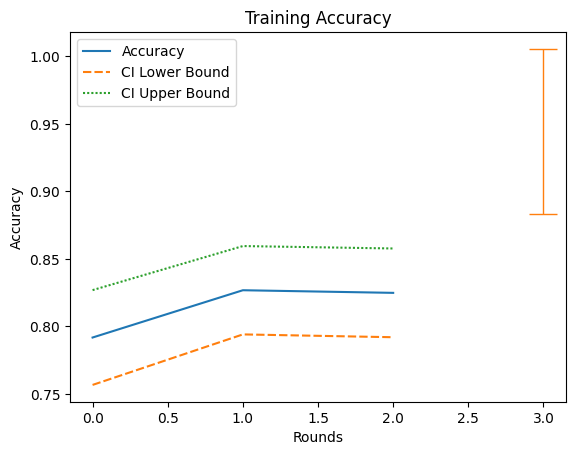

2 0.98
False Negative % 0.0 False Positive % 0.02 

Misclassified observations: 1 / 54


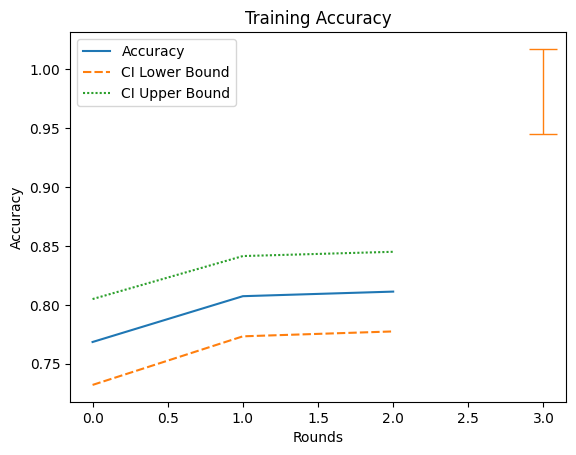

3 0.96
False Negative % 0.18 False Positive % 0.0 

Misclassified observations: 2 / 55


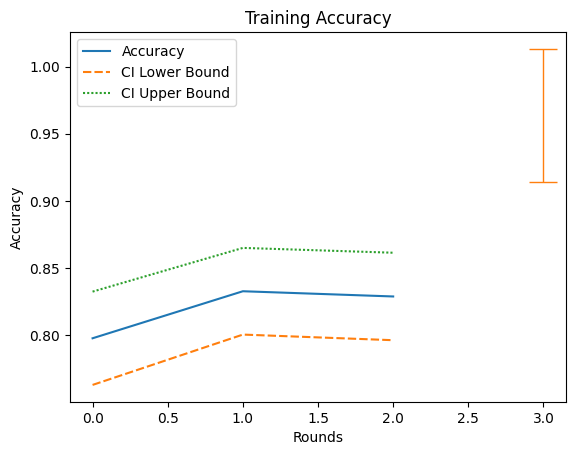

4 0.95
False Negative % 0.12 False Positive % 0.04 

Misclassified observations: 3 / 55


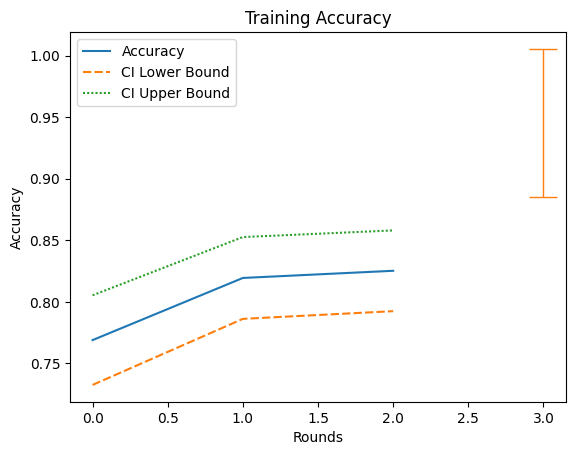

5 0.94
False Negative % 0.2 False Positive % 0.04 

Misclassified observations: 3 / 54


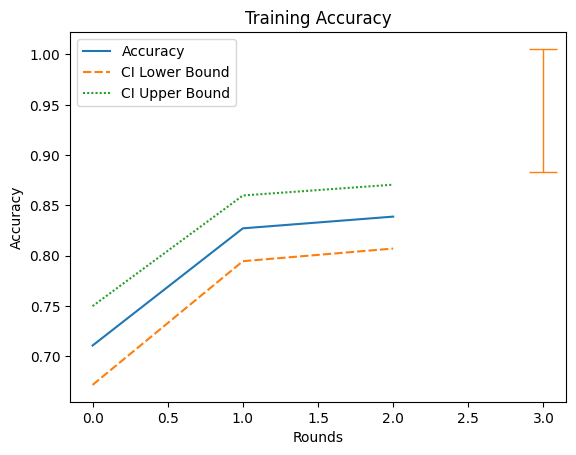

Mean Accuracy: 95.589 Std 0.01 Min/Max 0.94 0.98 Mean CI: 0.9 1.01 Mean False Negatives: 0.12 Mean False Positives: 0.03


In [1215]:
## Decide on k
k = 5

## Define threshold as 4 standard deviations from mean
std_threshold = 4

## Define how many nearest neighbors to use in potential imputation
n_nearest_neighbors = 3

## How many times to go train on the dataset before evaluating?
rounds_to_train = 3

## How many principal components should be used?
number_of_pcs = 0

## Learning Rate
LR = 0.000009

# Which columns to drop when standardizing and giving to model. 'Outcome' should be dropped
# If any other columns shold be dropped (for feature engineering purposes), these can be specified here as well:
drop_columns = ['Outcome']#, 'SkinThickness', 'Insulin']

# Which columns to log-transform?
log_columns = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

# Get all remaining columns in lists
features = [col for col in df.columns if col not in [kol for kol in drop_columns]]

## Create Data from DataFrame
X_data, Y_data, pc_array = k_split(df, k=k, RemoveOutliers=True, ImputeMissing=True, log_transform=log_columns,
                                        remove_misclassified = True)


## Perform cross validation
statistics, misclassified_observations = cross_validate(X_data,Y_data,pc_array, n_pcs=number_of_pcs, 
                                            learning_rate = LR, rtt=rounds_to_train, plot=True)

## Analyze the data
means, low_means, high_means, false_negatives, false_positives = [], [], [], [], []
for run_stat in statistics:
    means.append(run_stat[0])
    low_means.append(run_stat[1])
    high_means.append(run_stat[2])
    false_negatives.append(1-run_stat[3])
    false_positives.append(1-run_stat[4])
    
print('Mean Accuracy:', np.round(np.mean(means)*100,3), 'Std', np.round(np.std(means),2), 'Min/Max', np.round(min(means),2), 
      np.round(max(means),2), 'Mean CI:', np.round(np.mean(low_means),2), np.round(np.mean(high_means),2),
      'Mean False Negatives:', np.round(np.mean(false_negatives),2), 
      'Mean False Positives:', np.round(np.mean(false_positives),2))


# LR = 0.000001, std_threshold = 4, n_nearest_neighbors = 3, rounds_to_train = 4, number_of_pcs = 0
# drop_columns = ['Outcome', 'DiabetesPedigreeFunction'], 
# log_columns = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']      : mean 0.8